In [2]:
import pandas as pd
import numpy as np

cohort = pd.read_csv("/Users/burke/Documents/research/bpCog/combinedCohort.csv", low_memory=False)
cohort = cohort[['newid', 'visitcounter', 'SBP', 'DBP', 'bmi', 'trig', 'Smokestatus', 'choltot', 'cholhdl', 'cholldl', 
                 'age0', 'female0', 'educ0', 'daysfromvisit1', 'racebpcog', 'hba1c', 'glucosef']]

cohort['newid'] = cohort['newid'].str[2:]
cohort['newid'] = cohort['newid'].str[:-1]

cohort = cohort.assign(id=(cohort['newid']).astype('category').cat.codes)
cohort.drop(labels=['newid'], axis='columns', inplace=True)

cohort.rename(columns={'SBP' : 'sbp', 'DBP' : 'dbp', 'Smokestatus' : 'smokingStatus', 'choltot' : 'totChol',
                      "cholhdl" : 'hdl', 'cholldl' : 'ldl', 'age0' : 'baseAge', 'female0' : 'gender', 'educ0' : 'educ',
                      'hba1c' : 'a1c', 'racebpcog' : 'raceEthnicity'}, inplace=True)

cohort.gender.replace(to_replace=[0,1], value=[1, 2], inplace=True)
# have to compress "hispanic" to "other hispanic" and no representation for mexican american in BP Cog
cohort.raceEthnicity.replace(to_replace=[1,2,3,9], value=[4,3,2,5], inplace=True)

In [3]:
allFactorsImputation = ["a1c", "hdl", "totChol", "bmi", "dbp", "sbp", "ldl", "trig", "glucosef"]

lagVars = []

# first geneate lag variables which we'll use in teh imputatino
for factor in allFactorsImputation:
    newVarName = "lag" + factor[0].upper()+factor[1:]
    lagVars.append(newVarName)
    cohort[newVarName] = cohort.groupby(['id'])[factor].shift(1)
    cohort = cohort.join(other=cohort.groupby(['id'])[newVarName].mean(), on='id', rsuffix='mean')
    cohort.rename(columns={newVarName + "mean" : 'mean' + newVarName[0].upper() + newVarName[1:]}, inplace=True)
cohort.drop(lagVars, axis='columns', inplace=True)

cohort['age'] = cohort.baseAge + cohort.daysfromvisit1 / 365
cohort = pd.concat([cohort, pd.get_dummies(cohort['raceEthnicity'], prefix="raceEth")], axis=1)
cohort = pd.concat([cohort, pd.get_dummies(cohort['smokingStatus'], prefix="smoke")], axis=1)
cohort.drop(['baseAge', 'daysfromvisit1', 'visitcounter', 'smokingStatus', 'raceEthnicity', 'educ'], axis='columns', inplace=True)

cohort.rename(columns={'raceEth_2.0' : 'raceEth2', 'raceEth_3.0' : 'raceEth3', 'raceEth_4.0' : 'raceEth4',
                        'raceEth_5.0' : 'raceEth5', 'smoke_0.0' : 'smoke0', 'smoke_1.0' : 'smoke1' , 
                       'smoke_2.0' : 'smoke2'  }, inplace=True)


In [4]:
import statsmodels.imputation.mice as mice

def getFormulaForVariable(var):
    cols = list(cohort.columns)
    cols.remove(var)
    colStrings = [col + "+"for col in cols]
    return "".join(colStrings)[:-1]
    
imputedCohort = mice.MICEData(cohort)
binaryVars = ['smoke0', 'smoke1', 'smoke2', 'raceEth2', 'raceEth3', 'raceEth4', 'raceEth5']
for var in binaryVars:
    imputedCohort.set_imputer(var, formula=getFormulaForVariable(var), model_class="logit")
imputedCohort.update_all(20)

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [5]:
imputedCohort.results['a1c'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     9060.
Date:                Thu, 15 Nov 2018   Prob (F-statistic):               0.00
Time:                        09:57:28   Log-Likelihood:                -17316.
No. Observations:               41246   AIC:                         3.469e+04
Df Residuals:                   41219   BIC:                         3.492e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3754      0.023     16.056      0.000       0.330       0.421
x1            -0.0004      0.000     -2.420      0.016      -0.001   -7.94e-05
x2             0.0015      0.000      5.526      0.000       0.001       0.002
x3             0.0124      0.001     16.885      0.000       0.011       0.014
x4            -0.0001      0.000     -0.536      0.592      -0.001       0.000
x5            -0.0002      0.001     -0.166      0.868      -0.003       0.002
x6             0.0008      0.001      0.638      0.523      -0.002       0.003
x7             0.0001      0.001      0.093      0.926      -0.002       0.003
x8             0.0098      0.004      2.573      0.010       0.002       0.017
x9             0.0135   9.76e-05    138.511      0.000       0.013       0.014
x10         -1.78e-06   2.22e-07     -8.011      0.000   -2.22e-06   -1.34e-06
x11            0.8329      0.003    280.006      0.000       0.827       0.839
x12           -0.0022      0.001     -3.989      0.000      -0.003      -0.001
x13            0.0015      0.001      2.877      0.004       0.000       0.002
x14           -0.0124      0.001    -14.517      0.000      -0.014      -0.011
x15           -0.0021      0.000     -7.277      0.000      -0.003      -0.002
x16           -0.0007      0.000     -3.024      0.002      -0.001      -0.000
x17           -0.0016      0.001     -3.103      0.002      -0.003      -0.001
x18        -4.836e-05   9.75e-05     -0.496      0.620      -0.000       0.000
x19           -0.0100      0.000    -68.711      0.000      -0.010      -0.010
x20            0.0060      0.000     27.443      0.000       0.006       0.006
x21            0.1140      0.008     13.481      0.000       0.097       0.131
x22            0.0396      0.007      5.866      0.000       0.026       0.053
x23            0.1086      0.008     13.246      0.000       0.092       0.125
x24            0.1133      0.010     11.293      0.000       0.094       0.133
x25           -0.0147      0.005     -2.841      0.004      -0.025      -0.005
x26           -0.0131      0.005     -2.434      0.015      -0.024      -0.003
x27            0.0040      0.007      0.554      0.580      -0.010       0.018
==============================================================================
Omnibus:                    17889.998   Durbin-Watson:                   2.131
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1211861.682
Skew:                           1.249   Prob(JB):                         0.00
Kurtosis:                      29.437   Cond. No.                     2.55e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.57e-18. This might indic

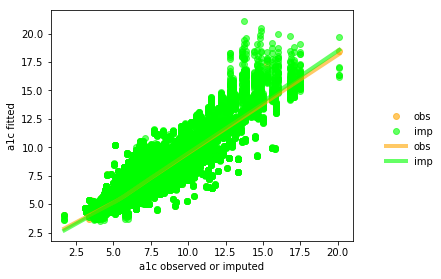

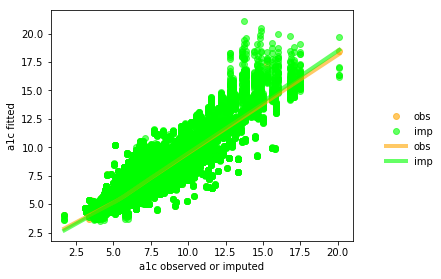

In [6]:
%matplotlib inline
imputedCohort.plot_fit_obs("a1c")

In [35]:
imputedData = imputedCohort.data.copy()

# rebvuild categoricals
imputedData['smokingStatus'] = imputedData[['smoke0', 'smoke1', 'smoke2']].idxmax(axis=1)
imputedData['smokingStatus'] = imputedData['smokingStatus'].str[-1:]
imputedData['raceEthnicity'] = imputedData[['raceEth2', 'raceEth3', 'raceEth4', 'raceEth5']].idxmax(axis=1)
imputedData['raceEthnicity'] = imputedData['raceEthnicity'].str[-1:]


In [36]:
# drop the dummies
imputedData.drop(['smoke0', 'smoke1','smoke2'], axis='columns', inplace=True)
imputedData.drop(['raceEth2', 'raceEth3','raceEth3', 'raceEth4', 'raceEth5'], axis='columns', inplace=True)


# drop the mean variables (they were partially imputed)
imputedData.drop(list(imputedData.filter(regex='mean')), axis='columns', inplace=True)


# rebuild the mean variables off the impuated values
allFactorsImputation = ["a1c", "hdl", "totChol", "bmi","ldl", "trig", "glucosef"]
logFactorsImputation = ["dbp", "sbp"]

In [37]:
for factor in allFactorsImputation:
    newVarName = "lag" + factor[0].upper()+factor[1:]
    imputedData[newVarName] = imputedData.groupby(['id'])[factor].shift(1)
    imputedData = imputedData.join(other=imputedData.groupby(['id'])[newVarName].mean(), on='id', rsuffix='mean')
    imputedData.rename(columns={newVarName + "mean" : 'mean' + newVarName[0].upper() + newVarName[1:]}, inplace=True)

In [38]:
for factor in logFactorsImputation:
    newVarName = "lag" + factor[0].upper()+factor[1:]
    imputedData[newVarName] = imputedData.groupby(['id'])[factor].shift(1)
    logLagName = "log" + newVarName[0].upper() + newVarName[1:]
    logName = "log" + factor[0].upper() + factor[1:]

    imputedData[logName] = np.log(imputedData[factor])  
    imputedData[logLagName] = np.log(imputedData[newVarName])  
    imputedData = imputedData.join(other=imputedData.groupby(['id'])[logLagName].mean(), on='id', rsuffix='mean')
    imputedData.rename(columns={logLagName + "mean" : 'mean' + logLagName[0].upper() + logLagName[1:]}, inplace=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


In [39]:
imputedData.raceEthnicity= imputedData.raceEthnicity.astype('category')
imputedData.smokingStatus= imputedData.smokingStatus.astype('category')
imputedData.sort_values(by=['id', 'age'], inplace=True)

In [40]:
imputedData.raceEthnicity.value_counts()



3    177722
4     61078
2     36458
5      5528
Name: raceEthnicity, dtype: int64

In [41]:
import statsmodels.formula.api as statsmodel

regResults = {}

def buildAndExportRegressionModelForDataset(outcomeVariable , fullDataset, hasLog): 
    factors = allFactors.copy()
    factors.extend(logFactors)
    factors.remove(outcomeVariable)
    factors = ["mean" + factor[0].upper() + factor[1:] + " + " + factor + " + " for factor in factors] 
    
    meanLagOutcomeVariable =  "mean" + outcomeVariable[0].upper() + outcomeVariable[1:]
    
    if (not hasLog):
        outcomeVariable = outcomeVariable[3:4].lower() + outcomeVariable[4:] # remove the lag
    else:
        outcomeVariable = "log" + outcomeVariable[-3:] # remove the lag and add the log
    
    formula = outcomeVariable + " ~ " + "".join(factors) + "age + gender + smokingStatus + raceEthnicity + " + meanLagOutcomeVariable

    print("outcome: " + outcomeVariable + " hasLog: " + str(hasLog) + " : " +formula)

    model = statsmodel.ols(formula=formula, data=fullDataset)
    results = model.fit()
    regResults[outcomeVariable] = results
    results.save("/Users/burke/Documents/research/bpCog/mcm/mcm/data/" + outcomeVariable +  "CohortModel.pickle")
    return results


allFactors = ["lagA1c", "lagHdl", "lagTotChol", "lagBmi", "lagLdl", "lagTrig"]
logFactors = ["logLagDbp", "logLagSbp"]

imputedData['logDbp'].loc[imputedData['logDbp'] <= 0] = imputedData['logDbp'].loc[imputedData['logDbp']> 0].min()
imputedData['logLagDbp'].loc[imputedData['logLagDbp'] <= 0] = imputedData['logLagDbp'].loc[imputedData['logLagDbp']> 0].min()
imputedData['meanLogLagDbp'].loc[imputedData['meanLogLagDbp'] <= 0] = imputedData['meanLogLagDbp'].loc[imputedData['meanLogLagDbp']> 0].min()



for factor in allFactors:
    buildAndExportRegressionModelForDataset(factor, imputedData, False)
for factor in logFactors:
    buildAndExportRegressionModelForDataset(factor, imputedData, True)
    

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


outcome: a1c hasLog: False : a1c ~ meanLagHdl + lagHdl + meanLagTotChol + lagTotChol + meanLagBmi + lagBmi + meanLagLdl + lagLdl + meanLagTrig + lagTrig + meanLogLagDbp + logLagDbp + meanLogLagSbp + logLagSbp + age + gender + smokingStatus + raceEthnicity + meanLagA1c
outcome: hdl hasLog: False : hdl ~ meanLagA1c + lagA1c + meanLagTotChol + lagTotChol + meanLagBmi + lagBmi + meanLagLdl + lagLdl + meanLagTrig + lagTrig + meanLogLagDbp + logLagDbp + meanLogLagSbp + logLagSbp + age + gender + smokingStatus + raceEthnicity + meanLagHdl
outcome: totChol hasLog: False : totChol ~ meanLagA1c + lagA1c + meanLagHdl + lagHdl + meanLagBmi + lagBmi + meanLagLdl + lagLdl + meanLagTrig + lagTrig + meanLogLagDbp + logLagDbp + meanLogLagSbp + logLagSbp + age + gender + smokingStatus + raceEthnicity + meanLagTotChol
outcome: bmi hasLog: False : bmi ~ meanLagA1c + lagA1c + meanLagHdl + lagHdl + meanLagTotChol + lagTotChol + meanLagLdl + lagLdl + meanLagTrig + lagTrig + meanLogLagDbp + logLagDbp + meanLo

In [43]:
regResults['logSbp'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 logSbp   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                 1.822e+04
Date:                Thu, 15 Nov 2018   Prob (F-statistic):               0.00
Time:                        11:17:13   Log-Likelihood:             2.2714e+05
No. Observations:              239623   AIC:                        -4.542e+05
Df Residuals:                  239600   BIC:                        -4.540e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.1043      0.008     12.981      0.000       0.089       0.120
smokingStatus[T.1]     0.0027      0.000      5.640      0.000       0.002       0.004
smokingStatus[T.2]     0.0032      0.001      4.854      0.000       0.002       0.005
raceEthnicity[T.3]    -0.0029      0.001     -4.545      0.000      -0.004      -0.002
raceEthnicity[T.4]    -0.0039      0.001     -5.470      0.000      -0.005      -0.003
raceEthnicity[T.5]    -0.0010      0.002     -0.634      0.526      -0.004       0.002
meanLagA1c             0.0017      0.000      5.246      0.000       0.001       0.002
lagA1c                -0.0003      0.000     -1.046      0.296      -0.001       0.000
meanLagHdl          -7.03e-05      0.000     -0.491      0.624      -0.000       0.000
lagHdl                 0.0001   6.37e-05      2.182      0.029    1.41e-05       0.000
meanLagTotChol      3.558e-05      0.000      0.252      0.801      -0.000       0.000
lagTotChol         -3.631e-05   5.74e-05     -0.633      0.527      -0.000    7.62e-05
meanLagBmi             0.0008      0.000      6.950      0.000       0.001       0.001
lagBmi                -0.0010      0.000     -9.304      0.000      -0.001      -0.001
meanLagLdl          4.084e-06      0.000      0.029      0.977      -0.000       0.000
lagLdl              8.262e-05   5.72e-05      1.443      0.149   -2.96e-05       0.000
meanLagTrig        -1.705e-06   2.69e-05     -0.063      0.949   -5.44e-05     5.1e-05
lagTrig             1.273e-05   1.03e-05      1.240      0.215   -7.39e-06    3.28e-05
meanLogLagDbp         -0.0115      0.002     -6.010      0.000      -0.015      -0.008
logLagDbp              0.0021      0.002      1.366      0.172      -0.001       0.005
age                   -0.0002    1.7e-05     -9.753      0.000      -0.000      -0.000
gender                 0.0020      0.000      4.871      0.000       0.001       0.003
meanLogLagSbp          0.9855      0.002    472.767      0.000       0.981       0.990
==============================================================================
Omnibus:                     9661.572   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            27803.036
Skew:                          -0.147   Prob(JB):                         0.00
Kurtosis:                       4.643   Cond. No.                     1.96e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.96e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [34]:
imputedData.logLagDbp.describe()

count    2.396230e+05
mean             -inf
std               NaN
min              -inf
25%      4.219508e+00
50%      4.343805e+00
75%      4.488636e+00
max      5.192957e+00
Name: logLagDbp, dtype: float64

ok...mdels are looking a bit bette rnow. sbp model looks reasonbly close to stata model which is reassureing.

other thought...
if we systematically name the variables here, it may be relatively easy to build a risk model apparatus that reads from these files and implements them. so, "log" means that the predictor is log-transformed. "meanLab" means that you take the maen of all prior values. "lag" means that you take the the value immediately before.

then you can include variable names in snake case — so each variable is multiple in. you'd be able to specify multi-way interactions or quadratic terms pretty easily that way... 